In [1]:
%matplotlib inline

In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [101]:
def process_bigdl_log(logfname,epoch_size):
    result = {}
    import re  
    trainiter = re.compile('.*(\d+/\d+/\d+\s+\d+\:\d+\:\d+)\s+INFO\s+optim\.DistriOptimizer\$\:\s+\[Epoch\s+(\d+)\s+(\d+)\/\d+\]\[Iteration\s+(\d+)\]\[Wall\s+Clock\s+(\d+\.\d+)s\]\s+Train\s+(\d+)\s+in\s+(\d+.\d+)\s*seconds\.\s+Throughput\s+is\s+(\d+\.\d+)\s+records\/second\.\s+Loss\s+is\s+(\d+.\d+)\.')
    epochfinish = re.compile('.*(\d+/\d+/\d+\s+\d+\:\d+\:\d+)\s+INFO\s+optim\.DistriOptimizer\$\:\s+\[Epoch\s+(\d+)\s+(\d+)\/\d+\]\[Iteration\s+(\d+)\]\[Wall\s+Clock\s+(\d+\.\d+)s\]\s+Epoch\s+finished\.\s+Wall\s+clock\s+time\s+is\s+([-+]?(\d+([.,]\d*)?|[.,]\d+)([eE][-+]?\d+)?)ms')
    valloss = re.compile('.*(\d+/\d+/\d+\s+\d+\:\d+\:\d+)\s+INFO\s+optim\.DistriOptimizer\$\:\s+.*Loss\s+is\s+\(Loss\:\s+(\d+\.\d+),\s+count\:\s+\d+,\s+Average\s+Loss\:\s+(\d+\.\d+)\)')
    top1acc = re.compile('.*(\d+/\d+/\d+\s+\d+\:\d+\:\d+)\s+INFO\s+optim\.DistriOptimizer\$\:\s+top1\s+accuracy\s+is\s+Accuracy\(correct\:\s+\d+,\s+count\:\s+\d+,\s+accuracy\:\s+(\d+\.\d+)\)')
    top5acc = re.compile('.*(\d+/\d+/\d+\s+\d+\:\d+\:\d+)\s+INFO\s+optim\.DistriOptimizer\$\:\s+top5\s+accuracy\s+is\s+Accuracy\(correct\:\s+\d+,\s+count\:\s+\d+,\s+accuracy\:\s+(\d+\.\d+)\)')

    with open(logfname) as logf:
        contents = logf.readlines()
        print len(contents)," of log lines to process"
        cur_iter = 0
        cur_epoch = 0
        for log in contents:
            trainiterm = trainiter.match(log)
            epochfinishm = epochfinish.match(log)
            vallossm = valloss.match(log)
            testtop1accm = top1acc.match(log)
            testtop5accm = top5acc.match(log)
            if trainiterm:
                #print trainiterm
                cur_epoch,processed_size,cur_iter,wall,bs,traintime,tput,loss = [eval(n) for n in trainiterm.groups()[1:]]
                result[cur_iter] = {'epoch':cur_epoch,'loss':loss,'lr':0,'top1':0}
            elif epochfinishm:
                cur_epoch = eval(epochfinishm.group(2))
                cur_iter = eval(epochfinishm.group(4))
                result[cur_iter] = result.get(cur_iter,{})
                result[cur_iter]['epoch'] = cur_epoch
                result[cur_iter]['end_of_epoch'] = True
                #print log
            elif vallossm:
                avg_loss=eval(vallossm.group(3))
                result[cur_iter]['valloss'] = avg_loss
            elif testtop1accm:
                top1=eval(testtop1accm.group(2))
                result[cur_iter]['testtop1'] = top1
            elif testtop5accm:
                top5=eval(testtop5accm.group(2))
                result[cur_iter]['testtop5'] = top5
            else:
                pass
        #prepare ndarrays for plotting
        train_tbl = np.zeros((5,len(result.keys()))) #iter,trainloss3
        test_tbl = np.zeros((6,len(result.keys()))) #iter,lr,trainloss3,testtop1,testtop5
        test_tbl_epoch = np.zeros((6,999))
        #print result
        #get all test results with train lr
        idx_train = 0
        idx_test = 0
        idx_test_epoch = 0
        for iter,values in sorted(result.items()):
            #print iter,values
            train_tbl[0][idx_train] = iter # iteration
            train_tbl[1][idx_train] = values['epoch'] #epoch
            train_tbl[2][idx_train] = values['lr']
            train_tbl[3][idx_train] = values['loss']
            idx_train = idx_train + 1
            if values.has_key('valloss') or values.has_key('testtop1') or values.has_key('testtop5'):
                #print iter,values
                test_tbl[0][idx_test] = iter # iteration
                test_tbl[1][idx_test] = values.get('lr',0)
                test_tbl[2][idx_test] = values.get('loss',0)
                test_tbl[3][idx_test] = values.get('testtop1',0)
                test_tbl[4][idx_test] = values.get('testtop5',0)
                test_tbl[5][idx_test] = values.get('valloss',0)
                idx_test = idx_test + 1
                if values.has_key('end_of_epoch'):
                    test_tbl_epoch[0][idx_test_epoch] = values.get('epoch') #epoch
                    test_tbl_epoch[1][idx_test_epoch] = values.get('lr',0)
                    test_tbl_epoch[2][idx_test_epoch] = values.get('loss',0)
                    test_tbl_epoch[3][idx_test_epoch] = values.get('testtop1',0)
                    test_tbl_epoch[4][idx_test_epoch] = values.get('testtop5',0)
                    test_tbl_epoch[5][idx_test_epoch] = values.get('valloss',0)
                    idx_test_epoch = idx_test_epoch + 1          
        print train_tbl[:,0:idx_train].shape[1],' train record found'
        print test_tbl[:,0:idx_test].shape[1],' test record found'
        print test_tbl_epoch[:,0:idx_test].shape[1],'test epoch record found'
        return train_tbl[:,:idx_train],test_tbl[:,:idx_test],test_tbl_epoch[:,:idx_test]
 
                

In [102]:
def process_log(fmat,log,epoch_size):
    if fmat=='caffe': 
        return process_caffe_log(log,epoch_size)
    elif fmat == 'torch':
        return process_torch_log(log,epoch_size)
    elif fmat == 'bigdl':
        return process_bigdl_log(log,epoch_size)
    else:
        print "unknown log format",fmat
        return None

In [103]:
tests = [  
    ('bigdl','old','/home/user/jupyter/old00',16),
    ('bigdl','job1','/home/user/jupyter/job00',57),
    ('bigdl','job2','/home/user/jupyter/job01',57),
    ('bigdl','job3','/home/user/jupyter/job02',57),
    ('bigdl','job4','/home/user/jupyter/job03',57),
    ('bigdl','job5','/home/user/jupyter/job04',71),
    
    #('bigdl','bigdl-512-step-b0.36-s400-part2','/home/user/shane/BigDL/bigdl-bs512-step-0.36-part2.log',57),
    #('bigdl','bigdl-512-step-b0.36-s400-addbn','/home/user/shane/BigDL/snap-bs512-step-0.36-yanzhangpr.log',128*10000/512),
    
]
result_tbls = []
for (fmat,label,log,epoch_size) in tests:
    print 'TEST ===',label,'==='
    print log
    train1,test1,test1_epoch = process_log(fmat,log,epoch_size)
    result_tbls.append({'label':label,'train_result':train1,'test_result':test1,'test_result_epoch':test1_epoch})

TEST === old ===
/home/user/jupyter/old00
2490  of log lines to process
2048  train record found
128  test record found
128 test epoch record found
TEST === job1 ===
/home/user/jupyter/job00
1025  of log lines to process
912  train record found
16  test record found
16 test epoch record found
TEST === job2 ===
/home/user/jupyter/job01
1032  of log lines to process
912  train record found
16  test record found
16 test epoch record found
TEST === job3 ===
/home/user/jupyter/job02
1032  of log lines to process
912  train record found
16  test record found
16 test epoch record found
TEST === job4 ===
/home/user/jupyter/job03
1033  of log lines to process
912  train record found
16  test record found
16 test epoch record found
TEST === job5 ===
/home/user/jupyter/job04
725  of log lines to process
632  train record found
8  test record found
8 test epoch record found


In [104]:
#### formattings
def plot_formats(num):
    #from itertools import cycle
    #lines = ["-","--"]
    #linecycler = cycle(lines)   
    color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']
    if num > len(color_sequence):
        print "not enough color sequence, add more colors"
        return
    lwidths = np.linspace(1,4,num)
    formats = [{'lw':lw,'color':color} for lw,color in zip(lwidths,color_sequence[0:num])]
    return formats

In [105]:
def plot_lr_iter(position,result_tbls,lineformats=None):
    ymax = 0
    ax=plt.subplot(position)
    plt.title('fig '+str(position%10)+': learning rate vs. iteration')
    if lineformats == None:
        for result in result_tbls:
            ymax = max(ymax,max(result['train_result'][2,:]))
            plt.plot(result['train_result'][0,:],result['train_result'][2,:],label=result['label'])
    else:
        for result,lineformat in zip(result_tbls,lineformats):
            ymax = max(ymax,max(result['train_result'][2,:]))
            plt.plot(result['train_result'][0,:],result['train_result'][2,:],label=result['label'],color=lineformat['color'])
    ax.legend(loc='upper right',fontsize=8)
    plt.grid(True)
    plt.xlabel('iteration')
    plt.ylabel('learning rate')
    plt.ylim((0,ymax*1.05))

In [106]:
def plot_lr_epoch(position,result_tbls,lineformats=None):
    ax=plt.subplot(position)
    plt.title('fig '+str(position%10)+': learning rate vs. epoch')
    ymax = 0
    if lineformats == None:
        for result in result_tbls:
            ymax = max(ymax,max(result['train_result'][2,:]))
            plt.plot(result['train_result'][1,:],result['train_result'][2,:],label=result['label'])
    else:
        for result,lineformat in zip(result_tbls,lineformats):
            ymax = max(ymax,max(result['train_result'][2,:]))
            plt.plot(result['train_result'][1,:],result['train_result'][2,:],label=result['label'],color=lineformat['color'])
    ax.legend(loc='upper right',fontsize=8)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.ylabel('learning rate')
    plt.ylim((0,ymax*1.05))
    

In [107]:
def plot_loss_iter(position,result_tbls,lineformats=None):
    ax=plt.subplot(position)
    plt.title('fig '+str(position%10)+': train loss vs. iteration')
    if lineformats == None:
        for result in result_tbls:
            plt.plot(result['train_result'][0,:],result['train_result'][3,:],label=result['label'])
    else:
        for result,lineformat in zip(result_tbls,lineformats):
            plt.plot(result['train_result'][0,:],result['train_result'][3,:],label=result['label'],color=lineformats['color'])
    ax.legend(loc='upper right',fontsize=8)
    plt.xlim(xmin=0)
    plt.grid(True)
    plt.xlabel('iteration')
    plt.ylabel('train loss')
    plt.ylim(ymin=0)

In [108]:
def plot_loss_epoch(position,result_tbls,lineformats=None):
    ax=plt.subplot(position)
    plt.title('fig '+str(position%10)+': train loss vs. epoch')
    if lineformats == None:
        for result in result_tbls:
            plt.plot(result['train_result'][1,:],result['train_result'][3,:],label=result['label'])
    else:
        for result,lineformat in zip(result_tbls,lineformats):
            plt.plot(result['train_result'][1,:],result['train_result'][3,:],label=result['label'],color=lineformat['color'])
    ax.legend(loc='upper right',fontsize=8)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.ylabel('train loss')
    plt.ylim(ymin=0)

In [109]:
def plot_valloss_iter(position,result_tbls,lineformats=None):
    ax=plt.subplot(position)
    plt.title('fig '+str(position%10)+': val loss vs. iteration')
    if lineformats == None:
        for result in result_tbls:
            plt.plot(result['test_result'][0,:],result['test_result'][5,:],label=result['label'])
    else:
        for result,lineformat in zip(result_tbls,lineformats):
            plt.plot(result['test_result'][0,:],result['test_result'][5,:],label=result['label'],color=lineformats['color'])
    ax.legend(loc='upper right',fontsize=8)
    plt.grid(True)
    plt.xlabel('iteration')
    plt.ylabel('validation loss')
    plt.ylim(ymin=0)

In [110]:
def plot_valloss_epoch(position,result_tbls,lineformats=None):
    ax=plt.subplot(position)
    plt.title('fig '+str(position%10)+': val loss vs. epoch')
    if lineformats == None:
        for result in result_tbls:
            plt.plot(result['test_result_epoch'][0,:],result['test_result_epoch'][5,:],label=result['label'])
    else:
        for result,lineformat in zip(result_tbls,lineformats):
            plt.plot(result['test_result_epoch'][0,:],result['test_result_epoch'][5,:],label=result['label'],color=lineformat['color'])
    ax.legend(loc='upper right',fontsize=8)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.ylabel('validation loss')
    plt.ylim(ymin=0)

In [111]:
def plot_top1_iter(position,result_tbls,lineformats=None):
    ax=plt.subplot(position)
    major_ticks = np.arange(0, 1.01, 0.1)                                              
    minor_ticks = np.arange(0, 1.01, 0.05)
    ax.set_yticks(major_ticks)                                                       
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2)                                                
    plt.title('fig '+str(position%10)+': top1 accr vs. iteration')
    if lineformats == None:
        for result in result_tbls:
            plt.plot(result['test_result'][0,:],result['test_result'][3,:],label=result['label'])
    else:
        for result,lineformat in zip(result_tbls,lineformats):
            plt.plot(result['test_result'][0,:],result['test_result'][3,:],label=result['label'],color=lineformat['color'])
    ax.legend(loc='lower right',fontsize=8)
    plt.grid(True)
    plt.xlabel('iteration')
    plt.ylabel('top1 accr')
    plt.ylim((0,1))
    plt.xlim(xmin=0)
    plt.ylim(ymin=0)

In [112]:
def plot_top5_iter(position,result_tbls,lineformats=None):
    #plot the error
    ax=plt.subplot(position)
    major_ticks = np.arange(0, 1.01, 0.1)                                              
    minor_ticks = np.arange(0, 1.01, 0.05)
    ax.set_yticks(major_ticks)                                                       
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2)                                                
    plt.title('fig '+str(position%10)+': top5 accr vs. iteration')
    if lineformats == None:
        for result in result_tbls:
            plt.plot(result['test_result'][0,:],result['test_result'][4,:],label=result['label'])
    else:
        for result,lineformat in zip(result_tbls,lineformats):
            plt.plot(result['test_result'][0,:],result['test_result'][4,:],label=result['label'],color=lineformat['color'])
    ax.legend(loc='lower right',fontsize=8)
    plt.grid(True)
    plt.ylim((0,1))
    plt.xlim(xmin=0)
    #=========== annotation begin ===========
    #the spot on 256-step
    #spot=(result_tbls[1]['test_result'][0,20],result_tbls[1]['test_result'][4,20])
    #plt.scatter([spot[0], ], [spot[1], ], 50, color='grey')
    #plt.annotate(r'iteration 200000',
    #             xy=(spot[0], spot[1]), xycoords='data',
    #             xytext=(+10, -50), textcoords='offset points', fontsize=10,
    #             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
    #the spot on 512-triangular2
    #spot=(result_tbls[3]['test_result'][0,98],result_tbls[3]['test_result'][4,98])
    #plt.scatter([spot[0], ], [spot[1], ], 50, color='grey')
    #plt.annotate(r'iteration 100000',
    #             xy=(spot[0], spot[1]), xycoords='data',
    #             xytext=(+10, +20), textcoords='offset points', fontsize=10,
    #             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
    #=========== annotation end ===========
    plt.xlim(xmin=0)
    plt.xlabel('iteration')
    plt.ylabel('top5 accr')

In [113]:
def plot_top1_epoch(position,result_tbls,lineformats=None):
    ax=plt.subplot(position)
    major_ticks = np.arange(0, 1.01, 0.1)                                              
    minor_ticks = np.arange(0, 1.01, 0.05)
    ax.set_yticks(major_ticks)                                                       
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2)                                                
    plt.title('fig '+str(position%10)+': top1 accr vs. epoch')
    if lineformats == None:
        for result in result_tbls:
            plt.plot(result['test_result_epoch'][0,:],result['test_result_epoch'][3,:],label=result['label'])
    else:
        for result,lineformat in zip(result_tbls,lineformats):
            plt.plot(result['test_result_epoch'][0,:],result['test_result_epoch'][3,:],label=result['label'],color=lineformat['color'])
    ax.legend(loc='lower right',fontsize=8)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.ylabel('top1 accr')
    plt.ylim((0,1))
    plt.xlim(xmin=0)

In [114]:
def plot_top5_epoch(position,result_tbls,lineformats=None):
    #plot the error
    ax=plt.subplot(position)
    major_ticks = np.arange(0, 1.01, 0.1)                                              
    minor_ticks = np.arange(0, 1.01, 0.05)
    ax.set_yticks(major_ticks)                                                       
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2)                                                
    plt.title('fig '+str(position%10)+': top5 accr vs. epoch')
    if lineformats == None:
        for result in result_tbls:
            plt.plot(result['test_result_epoch'][0,:],result['test_result_epoch'][4,:],label=result['label'])
    else:
        for result,lineformat in zip(result_tbls,lineformats):
            plt.plot(result['test_result_epoch'][0,:],result['test_result_epoch'][4,:],label=result['label'],color=lineformat['color'])
    ax.legend(loc='lower right',fontsize=8)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.ylabel('top5 accr')
    plt.ylim((0,1))
    plt.xlim(xmin=0)


In [115]:
def find_final_accuracy(testspecs,result_tbls):
    for test,result in zip(testspecs,result_tbls):
        print 'TEST MAX ACCURACY:',result['label']
        #am = result['test_result'].max(axis=1)
        if result['test_result'].shape[1] == 0:
            print "No test result available yet"
            continue
        maxind = result['test_result'].argmax(axis=1)
        print 'maxiter_top1 = ',result['test_result'][0,maxind[3]],'max_epoch_top1=',int(result['test_result'][0,maxind[3]]/test[3]),'top1acc =',result['test_result'][3,maxind[3]],'top5acc =',result['test_result'][4,maxind[3]]
        print 'maxiter_top5 = ',result['test_result'][0,maxind[4]],'max_epoch_top1=',int(result['test_result'][0,maxind[4]]/test[3]),'top1acc =',result['test_result'][3,maxind[4]],'top5acc =',result['test_result'][4,maxind[4]]
        maxind = result['train_result'].argmax(axis=1)
        minind = result['train_result'].argmin(axis=1)
        print 'max lr = ',result['train_result'][2,maxind[2]],'min lr = ',result['train_result'][2,minind[2]]
        

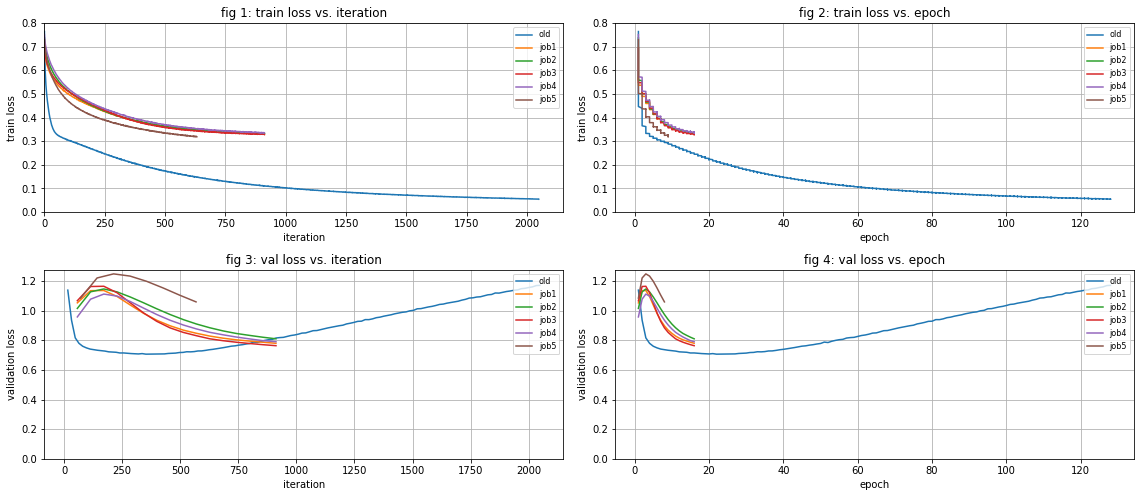

In [116]:
lineformats = plot_formats(len(result_tbls))
#plot the learning curve of one epoch
plt.figure(1,figsize=(16,10))
plt.title('Caffe Results')
lineformats = None

plot_loss_iter(321,result_tbls,lineformats)
plot_loss_epoch(322,result_tbls,lineformats)
plot_valloss_iter(323,result_tbls,lineformats)
plot_valloss_epoch(324,result_tbls,lineformats)
#plot_lr_iter(321,result_tbls,lineformats)
#plot_lr_epoch(322,result_tbls,lineformats)
#plot_top1_iter(323,result_tbls,lineformats)

#plot_top5_iter(324,result_tbls,lineformats)
#plot_top1_epoch(325,result_tbls,lineformats)

#plot_top5_epoch(326,result_tbls,lineformats)


plt.tight_layout()

#find_final_accuracy(tests,result_tbls)
